# Unsupervised Learning: Clustering Lab





In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import arff
import pandas as pd

## 1. Implement the HAC and K-means algorithms
For both algorithms:
- Use euclidean distance as the distance metric
- You only need to handle continuous features, but think about how you would handle nominal and unknown data
---
When reporting the results of each algorithm, include the following:
- The number of clusters (*k*)
- The silhouette score of the full clustering (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)

For each cluster include:
- The vectors of points representing the cluster centroid
- The number of instances tied to that centroid
---

### 1.1 HAC (Hierarchical Agglomerative Clustering)

### HAC Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from *n* to 1.  To reduce the amount of output implement a mechanism to specify for which *k* values actual output will be generated.

In [99]:
class HACClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
        
    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.k_clusters = {} # key: cluster number, value: list of points in cluster, array of centroids
        self.X = X

        # Create nxn distance matrix
        n = X.shape[0]
        dist_matrix = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                dist_matrix[i,j] = np.linalg.norm(X[i]-X[j])

        # Initialize each instance to be its own cluster
        clusters = [[i] for i in range(n)]
        # Add cluster to k_clusters dictionary
        self.k_clusters[len(clusters)] = clusters[:]

        # Merge clusters until there is just one cluster containing all instances
        while len(clusters) > 1:
            # Find the two clusters with the closest centroids
            min_dist = np.inf
            min_i = -1
            min_j = -1
            for i in range(len(clusters)):
                for j in range(i+1,len(clusters)):
                    if self.link_type == 'single':
                        dist = np.min(dist_matrix[clusters[i]][:,clusters[j]])
                    elif self.link_type == 'complete':
                        dist = np.max(dist_matrix[clusters[i]][:,clusters[j]])
                    else:
                        # average link because why not
                        # Find the distance between the centroids of the two clusters
                        centroid_i = np.mean(X[clusters[i]],axis=0)
                        centroid_j = np.mean(X[clusters[j]],axis=0)
                        dist = np.linalg.norm(centroid_i-centroid_j)

                    if dist < min_dist:
                        min_dist = dist
                        min_i = i
                        min_j = j

            # Merge the two clusters
            clusters[min_i] = clusters[min_i] + clusters[min_j]
            del clusters[min_j]

            # Add cluster to k_clusters dictionary
            self.k_clusters[len(clusters)] = clusters[:]

        self.labels = self.get_labels()

        return self
    
    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}\n".format(self.k))
        print("Silhouette score: {:.4f}\n\n".format(silhouette_score(self.X, self.labels, metric='euclidean')))

        # Find the centroids of each cluster
        centroids = [np.mean(self.X[np.array(cluster)], axis=0).astype(float) for cluster in self.k_clusters[self.k]]

        # For each cluster and centroid
        for i in range(self.k):
            print(np.array2string(np.array(centroids[i]),precision=4,separator=","))
            print("{:d}\n".format(len(self.k_clusters[self.k][i])))

    def get_labels(self):
        """
            Returns the labels for the data points
        """
        labels = np.zeros(self.X.shape[0])
        for i in range(self.k):
            labels[self.k_clusters[self.k][i]] = i
        return labels

    def get_silhuoeutte_score(self):
        """
            Returns the silhouette score for the clustering
        """
        return silhouette_score(self.X, self.labels, metric='euclidean')

### 1.1.1 (15%) Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points are commented out.

- Include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit normalization, else you will not get the same answers as us.
- Report results for *k* = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link%20%28Silhouette%29.txt)

[Debug HAC Complete (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link%20%28Silhouette%29.txt)

In [6]:
if not os.path.isfile("abalone.arff"):
    !curl -O https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff

In [7]:
# Debug Here
# Load data
data = arff.loadarff('abalone.arff')
df = pd.DataFrame(data[0])
data_np = df.to_numpy()

# Normalize data with (x-xmin)/(xmax-xmin)
for i in range(data_np.shape[1]):
    data_np[:,i] = (data_np[:,i] - np.min(data_np[:,i]))/(np.max(data_np[:,i]) - np.min(data_np[:,i]))

# Report results for k = 5 and single link
model_single = HACClustering(k=5,link_type='single')
model_single.fit(data_np, y=data_np[:,-1])
model_single.print_clusters()

# Report results for k = 5 and complete link
model_complete = HACClustering(k=5,link_type='complete')
model_complete.fit(data_np)
model_complete.print_clusters()


Num clusters: 5

Silhouette score: 0.3453


[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195

[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1

[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2

[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1

[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1

Num clusters: 5

Silhouette score: 0.3095


[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
71

[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
67

[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
38

[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
16

[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
8



Discussion

My HAC algorithm worked as follows: first, it creates a nxn distance matrix between all the points and initializes every data point to be its own cluster. Then it loops as long as there are more than one clusters combining clusters using either single-link or complete-link. It adds the clusters to a dictionary keeping track of every k value as it loops. 

After loading the debug dataset, I fit the HAC model with the single link type and then the complete link type. The results can be seen above, both of which match the debug solution files. The single-link model got a silhouette score of 0.3453 and the complete-link model got a silhouette score of 0.3095. It's interesting to note that with the single-link model, 195 out of the 200 data points were clustered together while the other 5 were in the 4 remaining clusters. The complete-link was a lot more balanced.

### 1.1.2 (15%) Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

#### Complete Link

In [8]:
if not os.path.isfile("seismic-bumps_train.arff"):
    !curl -O https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff

In [9]:
# Load evaluation data
data = arff.loadarff('seismic-bumps_train.arff')
df = pd.DataFrame(data[0])
data_np = df.to_numpy()

# Convert 'Class' row from b'1' and b'2' to integers 1 and 2
data_np[:,-1] = data_np[:,-1].astype(float)

# Normalize data with (x-xmin)/(xmax-xmin)
for i in range(data_np.shape[1]):
    data_np[:,i] = (data_np[:,i] - np.min(data_np[:,i]))/(np.max(data_np[:,i]) - np.min(data_np[:,i]))

# Train on evaluation data using complete link
eval_model_complete = HACClustering(k=5,link_type='complete')
eval_model_complete.fit(data_np)

# Print clusters
eval_model_complete.print_clusters()

Num clusters: 5

Silhouette score: 0.2930


[0.3636,0.4107,0.5609,0.3857,0.3937,0.2808,0.3155,0.    ]
49

[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
3

[0.1656,0.2226,0.3509,0.2328,0.152 ,0.3424,0.1918,0.    ]
18

[0.7918,0.8268,0.606 ,0.7669,0.7787,0.4634,0.7877,1.    ]
49

[0.5326,0.6002,0.4536,0.5531,0.5144,0.5401,0.6266,1.    ]
21



#### Single Link

In [10]:
# Load evaluation data
# Train on evaluation data using single link
eval_model_single = HACClustering(k=5,link_type='single')
eval_model_single.fit(data_np)

# Print clusters
eval_model_single.print_clusters()

Num clusters: 5

Silhouette score: 0.3971


[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1

[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70



Discussion

For the evaluation dataset, I had to make sure to change the last column from bytes to floats, which caused some problems initially. Otherwise it was pretty straightforward. My results for both the complete-link and single-link model are printed above. The complete-link model got a silhouette score of 0.2930 while the single-link model did better with a silhouette score of 0.3971. I thought it was interesting that the single-link model had most of the data in 2 clusters with the other three clusters containing only 1 data point each. The complete-link model was a little more balanced, with a majority of the data being distributed over 4 of the 5 clusters.

### 1.2 K-means

### Code requirements 
- Ability to choose *k* and specify the *k* initial centroids
- Ability to handle distance ties--when a node or cluster has the same distance to another cluster, which should be rare, choose the earliest cluster in your list

In [112]:
class KMEANSClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,debug=False): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug

    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.X = X.astype(float)

        # Randomly choose k instances from X to be the initial k centroids
        if self.debug:
            self.centroids = self.X[:self.k]
        else:
            self.centroids = self.X[np.random.choice(self.X.shape[0], self.k, replace=False),:]

        self.labels = self.get_labels()

        # self.clusters = {i:list() for i in range(self.k)}

        # Repeat until no (or negligible) more changes occur
        while True:
            self.clusters = {i:list() for i in range(self.k)}
            # Group each instance with its closest centroid
            for i in range(self.X.shape[0]):
                # Find the closest centroid to the instance
                closest_centroid = np.argmin(np.linalg.norm(self.centroids - self.X[i], axis=1))
                # Add the instance to the cluster of the closest centroid
                self.clusters[closest_centroid].append(self.X[i])

            # Calculate the new centroids
            new_centroids = np.zeros(self.centroids.shape)
            for i in range(self.k):
                new_centroids[i] = np.mean(np.array(self.clusters[i]), axis=0)

            # calculate new labels
            self.centroids = new_centroids
            new_labels = self.get_labels()
            
            # if the labels are the same as the previous iteration, stop
            if np.array_equal(self.labels, new_labels):
                break

            self.labels = new_labels
            
        return self
    
    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}\n".format(self.k))
        print("Silhouette score: {:.4f}\n\n".format(silhouette_score(self.X,self.labels)))
        for i in range(self.k):
            print(np.array2string(self.centroids[i],precision=4,separator=","))
            print("{:d}\n".format(len(self.clusters[i])))

    def get_labels(self):
        """
            Used for grading.
            return a list of labels for each instance in the order they were passed in.
        """
        labels = list()
        for i in range(self.X.shape[0]):
            # Find the closest centroid to the instance
            closest_centroid = np.argmin(np.linalg.norm(self.centroids - self.X[i], axis=1))
            labels.append(closest_centroid)
        return np.array(labels)

    def get_silhuoeutte_score(self):
        """
            Returns the silhouette score for the clustering
        """
        return silhouette_score(self.X, self.labels, metric='euclidean')

### 1.2.1 (10%) K-Means Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)

- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit nomralization, else you will not get the same answers as us.
- Use *k* = 5
- Use the first *k* instances in the training set as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

---
Solution in file:

[Debug K Means (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means%20%28Silhouette%29.txt)

In [90]:
# Load debug data
data = arff.loadarff('abalone.arff')
df = pd.DataFrame(data[0])
data_np = df.to_numpy()

# Normalize data with (x-xmin)/(xmax-xmin)
for i in range(data_np.shape[1]):
    data_np[:,i] = (data_np[:,i] - np.min(data_np[:,i]))/(np.max(data_np[:,i]) - np.min(data_np[:,i]))

# Train on debug data
model = KMEANSClustering(k=5,debug=True)
model.fit(data_np)

# Print clusters
model.print_clusters()

Num clusters: 5

Silhouette score: 0.3845


[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75

[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34

[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
24

[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
54

[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
13



Discussion

K-means was a little easier to implement for me. First the algorithm randomly chooses k instances from X to be the initial k centroids (unless debugging, then it just picks the first k data values). Then it repeatedly groups each instances with its closest centroid and then calculates new centroids from those values. It does this until convergence (no change in labels).

The silhouette score from the K-means model on the debug dataset was 0.3845 which was better than the single-link HAC and complete-link HAC models.

### 1.2.2 (15%) K-Means Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

In [91]:
# Load evaluation data
data = arff.loadarff('seismic-bumps_train.arff')
df = pd.DataFrame(data[0])
data_np = df.to_numpy()

# Convert 'Class' row from b'1' and b'2' to integers 1 and 2
data_np[:,-1] = data_np[:,-1].astype(float)

# Normalize data with (x-xmin)/(xmax-xmin)
for i in range(data_np.shape[1]):
    data_np[:,i] = (data_np[:,i] - np.min(data_np[:,i]))/(np.max(data_np[:,i]) - np.min(data_np[:,i]))

# Train on evaluation data
eval_model_complete = KMEANSClustering(k=5,debug=True)
eval_model_complete.fit(data_np)

# Print clusters
eval_model_complete.print_clusters()

Num clusters: 5

Silhouette score: 0.2769


[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
22

[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
31

[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
20

[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
19

[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
48



Discussion

The K-means didn’t do as well as the HAC algorithms on the eval dataset though. The clusters seemed well balanced though.

## 2. Iris Clustering with Both Alogrithms
For both algorithms: 
- Don't include the output label as one of the input features
- Normalize the data
- Show your results for clusterings with *k* = 2-7.  
- Graph the silhouette score for each *k* and discuss your results (i.e. what kind of clusters are being made).
- Load this Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

### 2.1 (10%) Iris Clustering with HAC

- Use single-link and complete link clustering algorithms
---

In [93]:
if not os.path.isfile("iris.arff"):
    !curl -O https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff

In [108]:
# Load iris data
data = arff.loadarff('iris.arff')
df = pd.DataFrame(data[0])
df = df.drop(columns=['class'])
data_np = df.to_numpy()

# Normalize data with (x-xmin)/(xmax-xmin)
for i in range(data_np.shape[1]):
    data_np[:,i] = (data_np[:,i] - np.min(data_np[:,i]))/(np.max(data_np[:,i]) - np.min(data_np[:,i]))


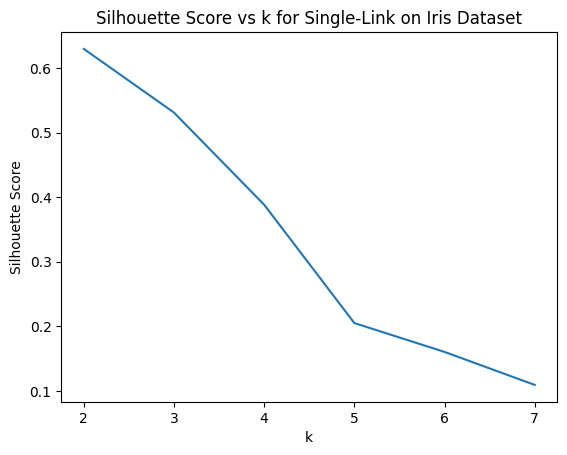

In [113]:
# Iris Clustering using single-link
k = [2,3,4,5,6,7]
scores = []
for i in k:
    model = HACClustering(k=i,link_type='single')
    model.fit(data_np)
    scores.append(model.get_silhuoeutte_score())

plt.plot(k,scores)
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k for Single-Link on Iris Dataset")
plt.show()

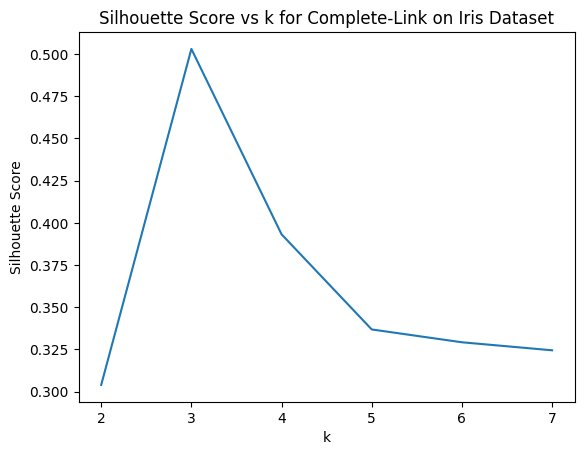

In [110]:
# Iris Clustering using complete-link
k = [2,3,4,5,6,7]
scores = []

for i in k:
    model = HACClustering(k=i,link_type='complete')
    model.fit(data_np)
    scores.append(model.get_silhuoeutte_score())

plt.plot(k,scores)
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k for Complete-Link on Iris Dataset")
plt.show()

Discuss your results including the differences between single-link and complete-link

As can be seen in the two plots above, the silhouette score appears to go down as k increases. This makes sense since there are really only 3 classes. It’s interesting to see that the single link results had the best k-value being 2. It only went down from there, though 3 still had a fairly high k-value. The complete-link results were different though. There, k=3 had the best silhouette score by far. As said before, this shows that it may have found the 3 classes of the iris dataset.

### 2.2 (10%) Iris Clustering with K-means

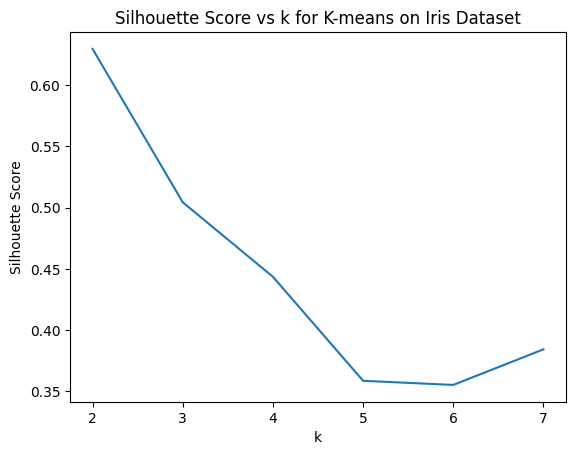

In [120]:
# Iris Clustering with K-means
k = [2,3,4,5,6,7]
scores = []

for i in k:
    model = KMEANSClustering(k=i, debug=False)
    model.fit(data_np)
    scores.append(model.get_silhuoeutte_score())

plt.plot(k,scores)
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k for K-means on Iris Dataset")
plt.show()

Discuss your results

As for K-means, the results looked similar to the single-link results, but then at the end, the silhouette score actually went back up a little. It defintely was better with a smaller k, though.

### 2.3 (5%) K-means Initial Centroids Experiment

- Run K-means 5 times with *k*=4, each time with different initial random centroids and discuss any variations in the results.
- If you ever end up with any empty clusters in K-means, re-run with different initial centroids.

In [125]:
#K-means 5 times
for i in range(5):
    model = KMEANSClustering(k=4, debug=False)
    model.fit(data_np)
    model.print_clusters()


Num clusters: 4

Silhouette score: 0.3983


[0.4413,0.3074,0.5757,0.5492]
61

[0.1286,0.483 ,0.0747,0.0463]
27

[0.7073,0.4509,0.797 ,0.8248]
39

[0.2754,0.7174,0.0833,0.0761]
23

Num clusters: 4

Silhouette score: 0.4435


[0.5496,0.377 ,0.6626,0.6558]
42

[0.1961,0.5908,0.0786,0.06  ]
50

[0.749 ,0.4769,0.8293,0.8673]
27

[0.3611,0.246 ,0.5156,0.4745]
31

Num clusters: 4

Silhouette score: 0.4446


[0.5417,0.375 ,0.6566,0.6419]
42

[0.3563,0.2371,0.5091,0.4713]
29

[0.1961,0.5908,0.0786,0.06  ]
50

[0.7385,0.4727,0.8229,0.8635]
29

Num clusters: 4

Silhouette score: 0.4446


[0.5417,0.375 ,0.6566,0.6419]
42

[0.7385,0.4727,0.8229,0.8635]
29

[0.3563,0.2371,0.5091,0.4713]
29

[0.1961,0.5908,0.0786,0.06  ]
50

Num clusters: 4

Silhouette score: 0.4446


[0.3563,0.2371,0.5091,0.4713]
29

[0.7385,0.4727,0.8229,0.8635]
29

[0.1961,0.5908,0.0786,0.06  ]
50

[0.5417,0.375 ,0.6566,0.6419]
42



Discuss any variations in the results

The different silhouette scores were as follows: 0.3983, 0.4435, 0.4446, 0.4446, 0.4446. These were all with k=4 and there was a little variation in the results. The first two runs had different results from the final three. 4 out of the 5 had really close silhouette scores to each other, with the first one being the most different from the rest at about .5 less than the rest of the results.

## 3. Scikit-Learn Comparison

### 3.1 (10%) Run the SK versions of HAC (just complete link) and K-means on Iris data set above

- Report results for a couple values of *k*
- Experiment using different hyper-parameters

In [146]:
# Load sklearn
# HAC first

model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
model.fit(data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=3, euclidean: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=3, affinity='l1', linkage='complete')
model.fit(data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=3, l1: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=3, affinity='l2', linkage='complete')
model.fit(data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=3, l2: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=3, affinity='manhattan', linkage='complete')
model.fit(data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=3, manhattan: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete')
model.fit(data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=3, cosine: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
model.fit(data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=3, euclidean, average linkage: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=3, euclidean, ward linkage: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

# k=4 with cosine distance
model = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='complete')
model.fit(data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=4, cosine: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

# k=4
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
model.fit(data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=4: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

# k=5
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
model.fit(data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=5: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

# k=6
model = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='complete')
model.fit(data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=6: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))


# K-means
model = KMeans(n_clusters=3, random_state=0).fit(data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=3: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

model = KMeans(n_clusters=4, random_state=0).fit(data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=4: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

model = KMeans(n_clusters=5, random_state=0).fit(data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=5: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

model = KMeans(n_clusters=6, random_state=0).fit(data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=6: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

model = KMeans(n_clusters=9, random_state=0).fit(data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=9: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

# Try different K-means algorithms
model = KMeans(n_clusters=3, random_state=0, algorithm='elkan').fit(data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=3, algorithm=elkan: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

# Try different K-means initialization methods
model = KMeans(n_clusters=3, random_state=0, init='k-means++').fit(data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=3, init=k-means++: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))

model = KMeans(n_clusters=3, random_state=0, init='random').fit(data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=3, init=random: {:.4f}".format(silhouette_score(data_np, labels, metric='euclidean')))




Sklearn complete-Link Silhouette Score k=3, euclidean: 0.5031
Sklearn complete-Link Silhouette Score k=3, l1: 0.4512
Sklearn complete-Link Silhouette Score k=3, l2: 0.5031
Sklearn complete-Link Silhouette Score k=3, manhattan: 0.4512
Sklearn complete-Link Silhouette Score k=3, cosine: 0.5309
Sklearn complete-Link Silhouette Score k=3, euclidean, average linkage: 0.5043
Sklearn complete-Link Silhouette Score k=3, euclidean, ward linkage: 0.5043
Sklearn complete-Link Silhouette Score k=4, cosine: 0.3034
Sklearn complete-Link Silhouette Score k=4: 0.3932
Sklearn complete-Link Silhouette Score k=5: 0.3368
Sklearn complete-Link Silhouette Score k=6: 0.3292
Sklearn K-means Silhouette Score k=3: 0.5043
Sklearn K-means Silhouette Score k=4: 0.4446
Sklearn K-means Silhouette Score k=5: 0.3519
Sklearn K-means Silhouette Score k=6: 0.3553
Sklearn K-means Silhouette Score k=9: 0.3269
Sklearn K-means Silhouette Score k=3, algorithm=elkan: 0.5043
Sklearn K-means Silhouette Score k=3, init=k-means++:

*Discuss Results and Comparison with your versions of the algorithms. Discuss effects of different hyperparameters*

As seen above, I tried a lot of different hyperparameters for both the complete-link HAC and the K-means algorithms. I first tried increasing the k, and for both algorithms, the higher the k I chose, the worse the score. 

On the HAC models, I tried all the different distance types. Euclidean and l2 got the same results (for k=3) of 0.5031, while the l1 and manhatan distances got the same results, but it was worse at 0.4512. The best distance metric seemed to be cosine, at a score of 0.5309. I also tried average linkage and ward linkage, which yielded the exact same results as single-linkage (all k=3 and euclidean distance).
The cosine distance didn't seem to improve the score when k=4. 

On the k-means models, there were not as many hyperparameters to play with. I tried changing the algorithm to elkan, which yieled the exact same result as the normal defalt lloyd algorithm. I also tried different initialization methods (k-means++ and random), both of which didn't seem to change anything. 

### 3.2 (10%) Run the SK version of HAC (just complete link) and K-means on a dataset of your choice 
- Report results for a couple values of *k*
- Experiment using different hyper-parameters

In [192]:
# Load pokemon data
data = pd.read_csv('pokemon.csv')
data = data[['hp','attack', 'defense','sp_attack', 'sp_defense', 'speed', 'is_legendary']]
print(data.head())

pokemon_data_np = data.values

# Normalize data with (x-xmin)/(xmax-xmin)
pokemon_data_np = (pokemon_data_np - pokemon_data_np.min(axis=0)) / (pokemon_data_np.max(axis=0) - pokemon_data_np.min(axis=0))


   hp  attack  defense  sp_attack  sp_defense  speed  is_legendary
0  45      49       49         65          65     45             0
1  60      62       63         80          80     60             0
2  80     100      123        122         120     80             0
3  39      52       43         60          50     65             0
4  58      64       58         80          65     80             0


In [207]:
# Load sklearn 

# HAC
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=2: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=3: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=4: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=5: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=6: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

# Try complete-linkage with different affinity
model = AgglomerativeClustering(n_clusters=2, affinity='l1', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=2, affinity=l1: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=2, affinity='l2', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=2, affinity=l2: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=2, affinity='manhattan', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=2, affinity=manhattan: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=2, affinity=cosine: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

# Try complete-linkage with different k with cosine
model = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=3, affinity=cosine: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=4, affinity=cosine: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = AgglomerativeClustering(n_clusters=10, affinity='cosine', linkage='complete')
model.fit(pokemon_data_np)
labels = model.labels_
print("Sklearn complete-Link Silhouette Score k=10, affinity=cosine: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

# K-means
model = KMeans(n_clusters=2, random_state=0).fit(pokemon_data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=2: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = KMeans(n_clusters=3, random_state=0).fit(pokemon_data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=3: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = KMeans(n_clusters=4, random_state=0).fit(pokemon_data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=4: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = KMeans(n_clusters=5, random_state=0).fit(pokemon_data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=5: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = KMeans(n_clusters=6, random_state=0).fit(pokemon_data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=6: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

# Try K-means with elkan and different k
model = KMeans(n_clusters=2, random_state=0, algorithm='elkan').fit(pokemon_data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=2, algorithm=elkan: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = KMeans(n_clusters=3, random_state=0, algorithm='elkan').fit(pokemon_data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=3, algorithm=elkan: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))

model = KMeans(n_clusters=4, random_state=0, algorithm='elkan').fit(pokemon_data_np)
labels = model.labels_
print("Sklearn K-means Silhouette Score k=4, algorithm=elkan: {:.4f}".format(silhouette_score(pokemon_data_np, labels, metric='euclidean')))



Sklearn complete-Link Silhouette Score k=2: 0.6162
Sklearn complete-Link Silhouette Score k=3: 0.6044
Sklearn complete-Link Silhouette Score k=4: 0.2584
Sklearn complete-Link Silhouette Score k=5: 0.2442
Sklearn complete-Link Silhouette Score k=6: 0.2249
Sklearn complete-Link Silhouette Score k=2, affinity=l1: 0.6162
Sklearn complete-Link Silhouette Score k=2, affinity=l2: 0.6162
Sklearn complete-Link Silhouette Score k=2, affinity=manhattan: 0.6162
Sklearn complete-Link Silhouette Score k=2, affinity=cosine: 0.0221
Sklearn complete-Link Silhouette Score k=3, affinity=cosine: 0.0122
Sklearn complete-Link Silhouette Score k=4, affinity=cosine: 0.1395
Sklearn complete-Link Silhouette Score k=10, affinity=cosine: 0.0883
Sklearn K-means Silhouette Score k=2: 0.6162
Sklearn K-means Silhouette Score k=3: 0.3019
Sklearn K-means Silhouette Score k=4: 0.2907
Sklearn K-means Silhouette Score k=5: 0.2820
Sklearn K-means Silhouette Score k=6: 0.2048
Sklearn K-means Silhouette Score k=2, algorithm=

*Discussion*

I used a pokemon dataset I got from kaggle that has 801 pokemon. I only kept the base state values for each pokemon and whether or not the pokemon is a legendary. I figured it would group them into 2 groups (non-legendary and legendary) best, so that's why k=2 seemed to be the best accross the board with all the hyperparameters (as can be seen above). It peaked at 0.6152, which it seemed to be able to get no matter the other hyperparameters while k=2.

## 4. (Optional 5% extra credit) Write your own code for silhouette
If you do this option implement your code for silhouette above in your main implementation and use it for your experiments. Make it clear that the silhouette results come from your code. You may/should compare with the SK version to debug/verify your results.

*Discussion*